# Demonstration of Robust Workflow with start_time > 0 feature

This notebook demonstrates the use of the RobustWorkflow class from the quends package when a start_time > 0 is passed in. 
This is a common situation when data comes from a gyrokinetic simulation that has been restarted from a different configuration and the data from this previous run should be ignored.

## Import Required Libraries and Helper Functions

In [2]:
# Import required libraries
import os
import numpy as np
import quends as qnds
import pprint
import matplotlib.pyplot as plt
import pandas as pd

# Custom class to specify formatting of floats (and tuples of floats) in pprint 
# and limit the number of significant digits in results dictionaries printed to screen
class FloatFormatter(pprint.PrettyPrinter):
    def _format(self, object, stream, indent, allowance, context, level):
        if isinstance(object, tuple):
            stream.write('(')
            for i, item in enumerate(object):
                if isinstance(item, float):
                    stream.write(format(item, '.4g'))
                else:
                    super()._format(item, stream, indent, allowance, context, level)
                if i < len(object) - 1:
                    stream.write(', ')
            stream.write(')')
        elif isinstance(object, float):
            stream.write(format(object, '.4g'))
        else:
            super()._format(object, stream, indent, allowance, context, level)

# use as 'formatter.pprint(object)'
formatter = FloatFormatter(indent=0)


## Demonstration on synthetic data
For these demonstrations, we set the verbosity to 2 so you can see plots of intermediate steps.

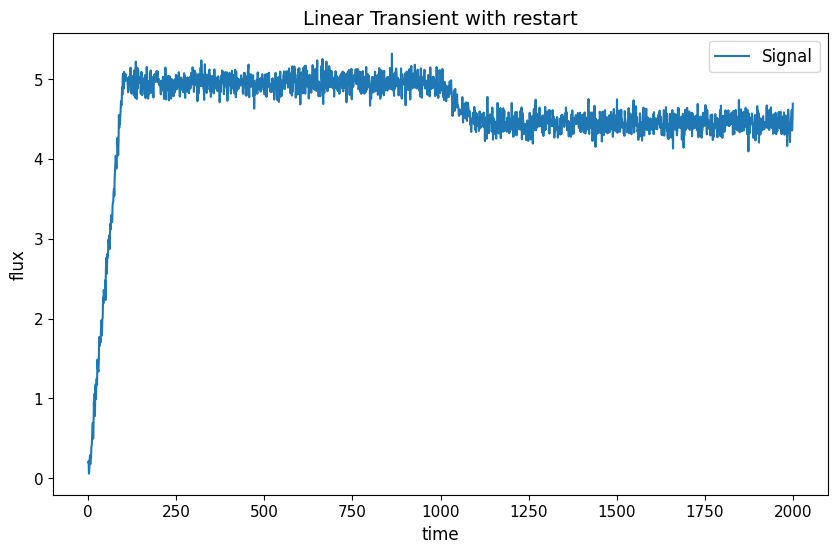

In [7]:
# Create time trace with linear transient up to flat signal with noise

# set up arrays for time and signal
arr_time = np.linspace(start=0,stop=2000,num=2001)
arr_signal = np.zeros_like(arr_time)

n_pts = arr_signal.shape[0]

for i_arr in range(100):
    arr_signal[i_arr] = 0.05*arr_time[i_arr]
for i_arr in range(100,1000):
    arr_signal[i_arr] = arr_signal[99]
for i_arr in range(1000,1100):
    arr_signal[i_arr] = arr_signal[999] -0.005*(arr_time[i_arr]-arr_time[999])
for i_arr in range(1100,n_pts):
    arr_signal[i_arr] = arr_signal[1099]

# add some noise
arr_signal += np.random.normal(loc=0.0, scale=0.1, size=arr_signal.shape)

my_label = "Linear Transient with restart"
# build data_stream
df_flat = pd.DataFrame({"time":arr_time,"flux":arr_signal})

ds_flat = qnds.DataStream(df_flat)

# Set up the workflow with high verbosity to see intermediate steps
my_wrkflw = qnds.RobustWorkflow(operate_safe=False, verbosity=2)

col = "flux" # variable to look at

# Plot raw signal
my_wrkflw.plot_signal_basic_stats(ds_flat,col,label=my_label)

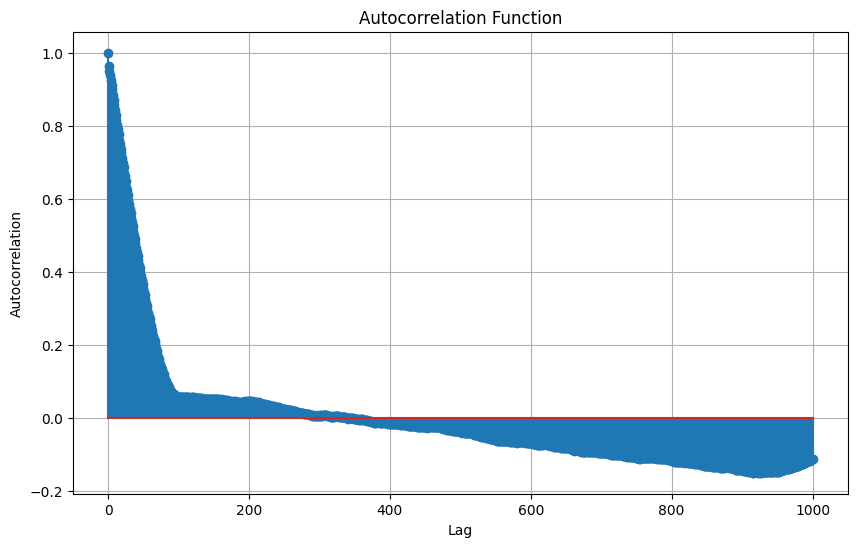

stats decorrelation length 194 gives smoothing window of 776 points.


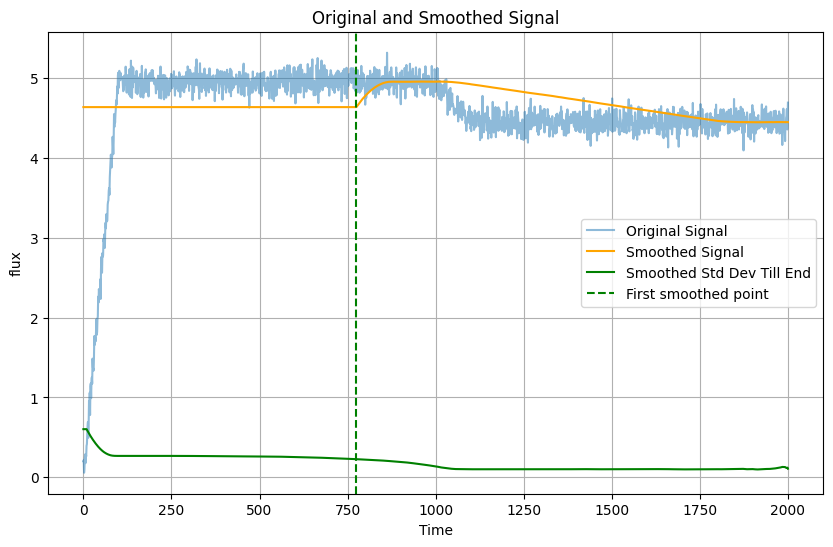

Getting start of SSS based on smoothed signal:
Index where criterion is met: 1165
Rolling window: 776
time where criterion is met: 1165.0
time at start of SSS (adjusted for rolling window): 544.0


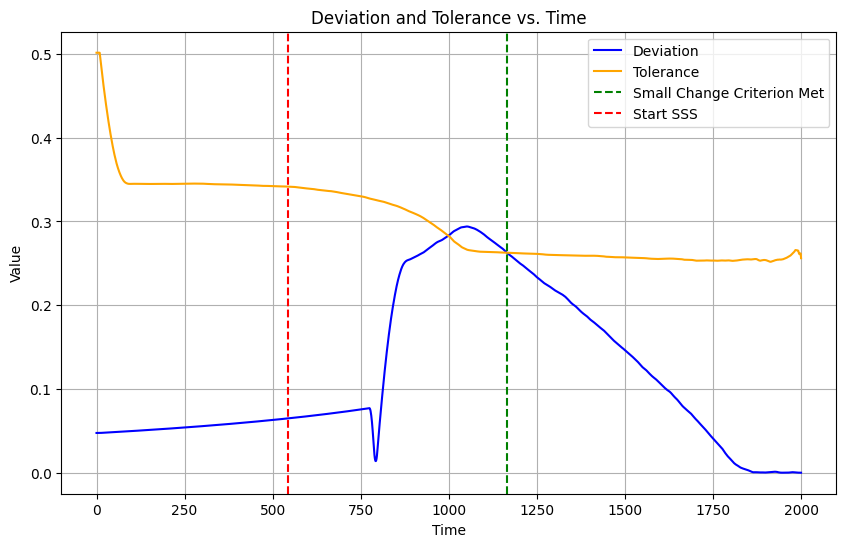

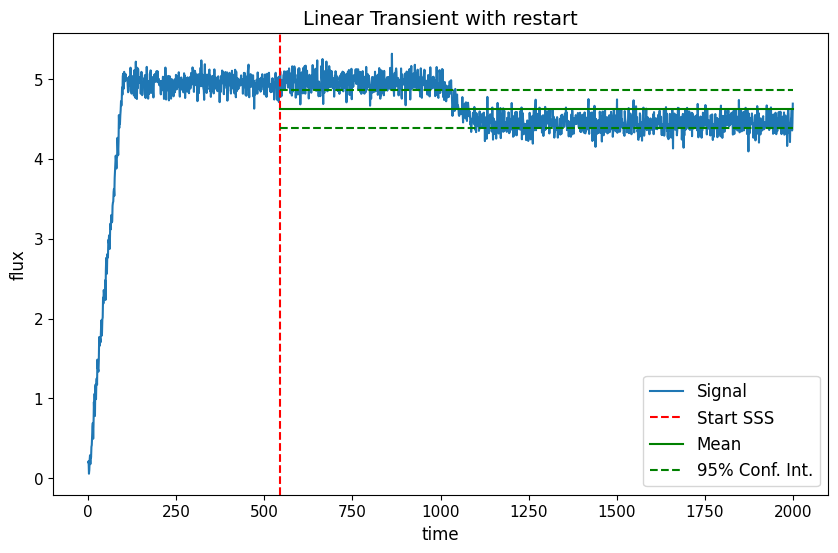

In [8]:
# get statistics without specifying the time of restart
my_stats = my_wrkflw.process_data_steam(ds_flat,col)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(ds_flat,col,stats=my_stats,label=my_label)

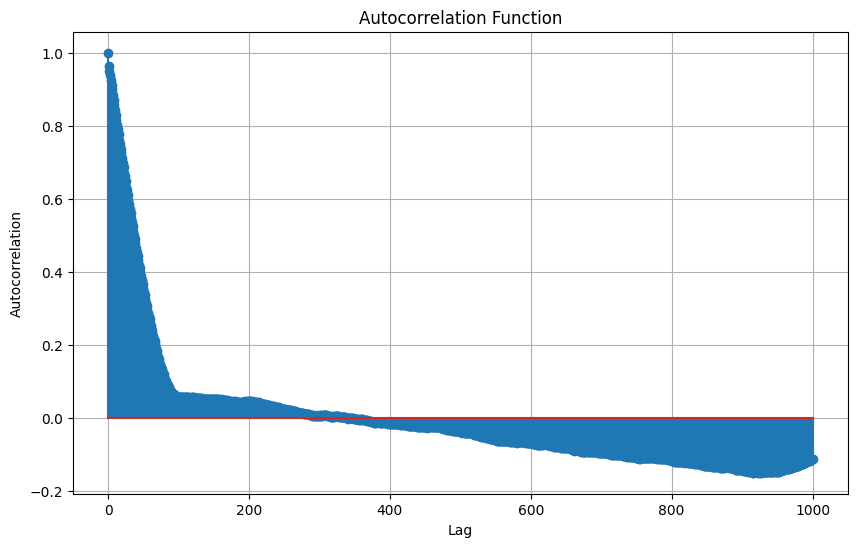

stats decorrelation length 194 gives smoothing window of 776 points.


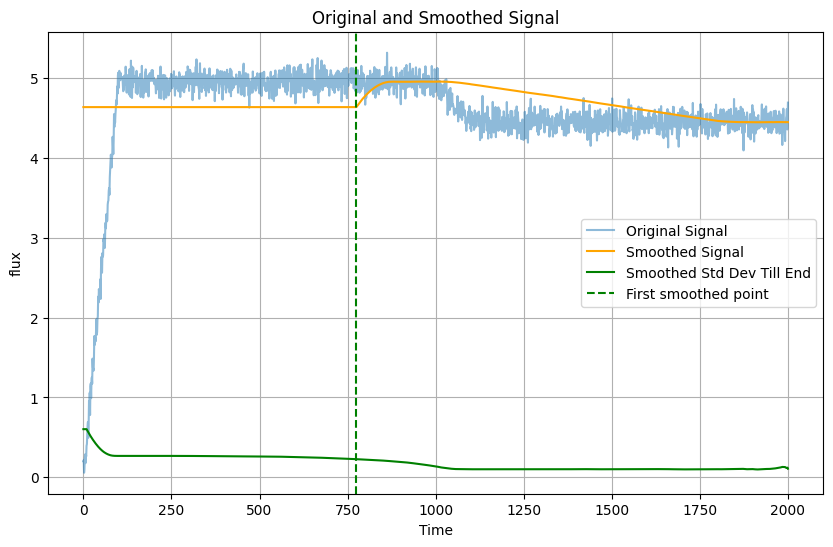

Getting start of SSS based on smoothed signal:
Index where criterion is met: 1165
Rolling window: 776
time where criterion is met: 1165.0
time at start of SSS (adjusted for rolling window): 544.0


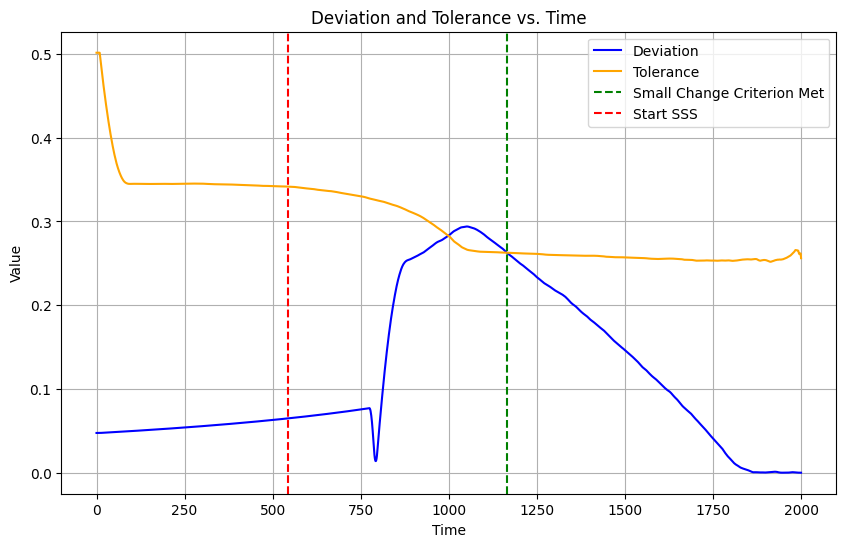

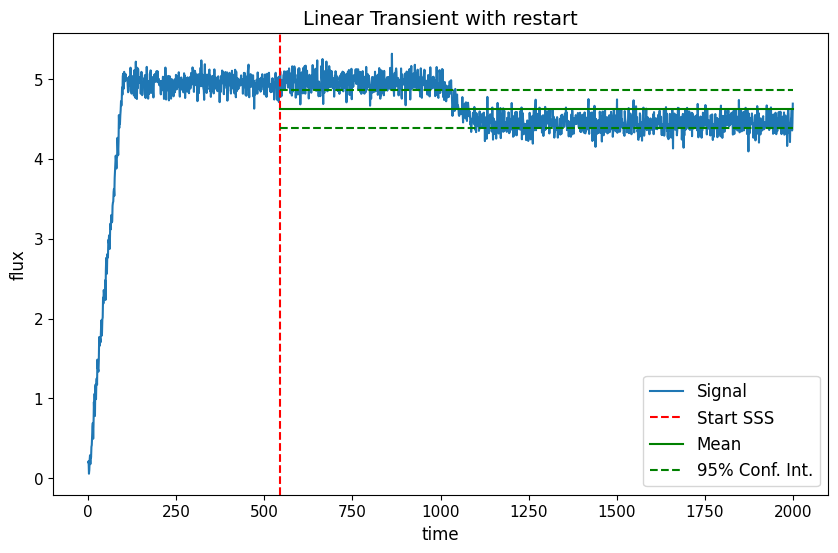

In [ ]:
# get statistics without specifying the time of restart
my_stats = my_wrkflw.process_data_steam(ds_flat,col, start_time=999.0)

# Plot trace with mean and start of steady state
if not my_stats[col]["metadata"]["mitigation"] == "Drop":
    my_wrkflw.plot_signal_basic_stats(ds_flat,col,stats=my_stats,label=my_label)

Because the change in levels between the two segments is small, the full signal is considered stationary. Because of the small level of white noise, and the smooth transition, this signal has a large decorrelation length. Even though the area with constant smoothed mean is properly detected, the large decorrelation length puts the start of SSS way back in the old regime. creating inaccurate statistics. 

Next we help the analysis by providing the time of restart of the configuration